In [844]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import MultiCursor
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

df = pd.read_csv('winequality-red.csv', sep=';')

print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

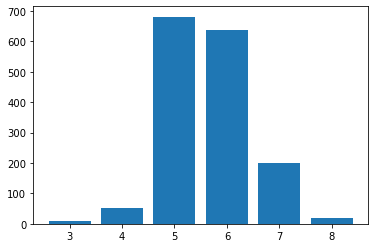

Mean of the quality : 5.6360225140712945
Standard deviation of the quality : 0.807569439734705
Median of the quality : 6.0


In [845]:
plt.bar(df['quality'].value_counts().index, df['quality'].value_counts().values)
plt.show()
print('Mean of the quality :', df['quality'].mean())
print('Standard deviation of the quality :', df['quality'].std())
print('Median of the quality :', df['quality'].median())

In [846]:
def make_binary(data):
    labels = data['quality']
    
    median = int(labels.median())
    mean = int(labels.mean())

    labels[labels < median] = 0
    labels[labels >= median] = 1

    return data

def normalize(data):

    norm = lambda x, x_max, x_min: (x - x_min) / (x_max - x_min)

    for column in list(data.columns):
        if column != "quality":

            temp = data[column].to_list()
            temp_max = max(temp)
            temp_min = min(temp)

            new_values = [norm(x, temp_max, temp_min) for x in temp]
            data[column] = new_values
    
    return data

def pipeline(data):

    data = normalize(data)
    data = make_binary(data)

    train, test, val = np.split(data.sample(frac=1), [int(data.shape[0] * 0.6), int(data.shape[0] * 0.8)])
    
    test_features = test.drop('quality', axis=1)
    test_labels = test['quality']

    train_features = train.drop('quality', axis=1)
    train_labels = train['quality']

    val_features = val.drop('quality', axis=1)
    val_labels = val['quality']

    train_tensor = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    test_tensor = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    val_tensor = tf.data.Dataset.from_tensor_slices((val_features, val_labels))

    train_tensor = train_tensor.shuffle(100).batch(20).prefetch(1)
    test_tensor = test_tensor.shuffle(100).batch(20).prefetch(1)
    val_tensor = val_tensor.shuffle(100).batch(20).prefetch(1)

    train_tensor = train_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    test_tensor = test_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    val_tensor = val_tensor.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

    train_tensor = train_tensor.cache()
    test_tensor = test_tensor.cache()
    val_tensor = val_tensor.cache()

    return train_tensor, test_tensor, val_tensor

In [847]:
train_tensor, test_tensor, val_tensor = pipeline(df)

In [848]:
""" Model """

class Dense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(Dense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x


class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = Dense(units=64, activation=tf.nn.sigmoid)
        self.dense2 = Dense(units=32, activation=tf.nn.sigmoid)
        self.out = Dense(units=1, activation=tf.nn.sigmoid)
    
    def call(self, inputs):
        """ Run data through network """
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        
        return x

    def training(self, input, target, loss, optimizer):
        """ Perform gradient descent and train variables """
        with tf.GradientTape() as tape:
            pred = self.call(input)
            loss_value = loss(target, pred)

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss_value

    def test(self, test_data, loss):
        """ Evaluate metrics """
        test_accuracy = []
        test_loss = []

        for (input, target) in test_data:
            pred = self.call(input)
            loss_value = loss(target, pred)

            sample_accuracy = np.round(pred, 0) == np.round(target, 0)
            sample_accuracy = np.mean(sample_accuracy)

            test_accuracy.append(np.mean(sample_accuracy))
            test_loss.append(loss_value.numpy())

        test_loss = tf.reduce_mean(test_loss)
        test_accuracy = tf.reduce_mean(test_accuracy)

        return test_loss, test_accuracy

In [849]:
model = Model()
model.build(input_shape=(20,64))
model.compile()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  4160      
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None


In [850]:
def training_loop(optimizer, epochs):
    """ External training loop """
    tf.keras.backend.clear_session()

    model = Model()

    loss = tf.keras.losses.BinaryCrossentropy()
    optimizer = optimizer(learning_rate=0.1)

    accuracies = []
    losses = []
    train_losses = []
    train_accuracies = []

    # Test runthrough
    test_loss, test_accuracy = model.test(test_tensor, loss)

    accuracies.append(test_accuracy)
    losses.append(test_loss)

    # Train runthrough
    train_loss, train_accuracy = model.test(train_tensor, loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('Optimizer: ',optimizer)
    print('Initial loss:', test_loss.numpy(), 'Initial accuracy:', test_accuracy.numpy(),'\n')

    for epoch in range(epochs):
      print(f'Epoch: {epoch}, accuracy of {accuracies[-1]}')

      epoch_loss = []

      for (input, target) in train_tensor:
          loss_value = model.training(input, target, loss, optimizer)
          epoch_loss.append(loss_value)

      train_losses.append(tf.reduce_mean(epoch_loss))
      train_accuracies.append(model.test(train_tensor, loss)[1])

      test_loss, test_accuracy = model.test(test_tensor, loss)
      accuracies.append(test_accuracy)
      losses.append(test_loss)

    print('\nFinal loss:', test_loss.numpy(), 'Final accuracy:', test_accuracy.numpy(),'\n')

    return accuracies, losses, train_accuracies, train_losses

In [851]:
sgd = training_loop(tf.keras.optimizers.SGD, epochs=10)

Optimizer:  <keras.optimizer_v2.gradient_descent.SGD object at 0x15b20fac0>
Initial loss: 0.6930543 Initial accuracy: 0.528125 

Epoch: 0, accuracy of 0.528125
Epoch: 1, accuracy of 0.528125
Epoch: 2, accuracy of 0.528125
Epoch: 3, accuracy of 0.528125
Epoch: 4, accuracy of 0.528125
Epoch: 5, accuracy of 0.528125
Epoch: 6, accuracy of 0.528125
Epoch: 7, accuracy of 0.528125
Epoch: 8, accuracy of 0.528125
Epoch: 9, accuracy of 0.528125

Final loss: 0.69704163 Final accuracy: 0.528125 



In [852]:
adam = training_loop(tf.keras.optimizers.Adam, epochs=10)

Optimizer:  <keras.optimizer_v2.adam.Adam object at 0x15b20f130>
Initial loss: 0.7102715 Initial accuracy: 0.47187499999999993 

Epoch: 0, accuracy of 0.47187499999999993
Epoch: 1, accuracy of 0.528125
Epoch: 2, accuracy of 0.528125
Epoch: 3, accuracy of 0.528125
Epoch: 4, accuracy of 0.53
Epoch: 5, accuracy of 0.50875
Epoch: 6, accuracy of 0.5121875
Epoch: 7, accuracy of 0.5103125
Epoch: 8, accuracy of 0.50875
Epoch: 9, accuracy of 0.5071875

Final loss: 0.5569951 Final accuracy: 0.5071875 



In [853]:
adagrad = training_loop(tf.keras.optimizers.Adagrad, epochs=10)

Optimizer:  <keras.optimizer_v2.adagrad.Adagrad object at 0x14eeb58e0>
Initial loss: 0.6917329 Initial accuracy: 0.528125 

Epoch: 0, accuracy of 0.528125
Epoch: 1, accuracy of 0.528125
Epoch: 2, accuracy of 0.528125
Epoch: 3, accuracy of 0.528125
Epoch: 4, accuracy of 0.528125
Epoch: 5, accuracy of 0.528125
Epoch: 6, accuracy of 0.528125
Epoch: 7, accuracy of 0.528125
Epoch: 8, accuracy of 0.528125
Epoch: 9, accuracy of 0.528125

Final loss: 0.6950195 Final accuracy: 0.528125 



In [854]:
adadelta = training_loop(tf.keras.optimizers.Adadelta, epochs=10)

Optimizer:  <keras.optimizer_v2.adadelta.Adadelta object at 0x168cd92b0>
Initial loss: 0.6998721 Initial accuracy: 0.47187499999999993 

Epoch: 0, accuracy of 0.47187499999999993
Epoch: 1, accuracy of 0.47187499999999993
Epoch: 2, accuracy of 0.519375
Epoch: 3, accuracy of 0.528125
Epoch: 4, accuracy of 0.528125
Epoch: 5, accuracy of 0.528125
Epoch: 6, accuracy of 0.528125
Epoch: 7, accuracy of 0.528125
Epoch: 8, accuracy of 0.528125
Epoch: 9, accuracy of 0.528125

Final loss: 0.69174707 Final accuracy: 0.528125 



In [855]:
rmsprop = training_loop(tf.keras.optimizers.RMSprop, epochs=10)

Optimizer:  <keras.optimizer_v2.rmsprop.RMSprop object at 0x15b20fd90>
Initial loss: 0.6978706 Initial accuracy: 0.47187499999999993 

Epoch: 0, accuracy of 0.47187499999999993
Epoch: 1, accuracy of 0.528125
Epoch: 2, accuracy of 0.528125
Epoch: 3, accuracy of 0.53
Epoch: 4, accuracy of 0.5303125
Epoch: 5, accuracy of 0.528125
Epoch: 6, accuracy of 0.52875
Epoch: 7, accuracy of 0.5278125
Epoch: 8, accuracy of 0.525
Epoch: 9, accuracy of 0.5259375000000001

Final loss: 0.57679033 Final accuracy: 0.526875 



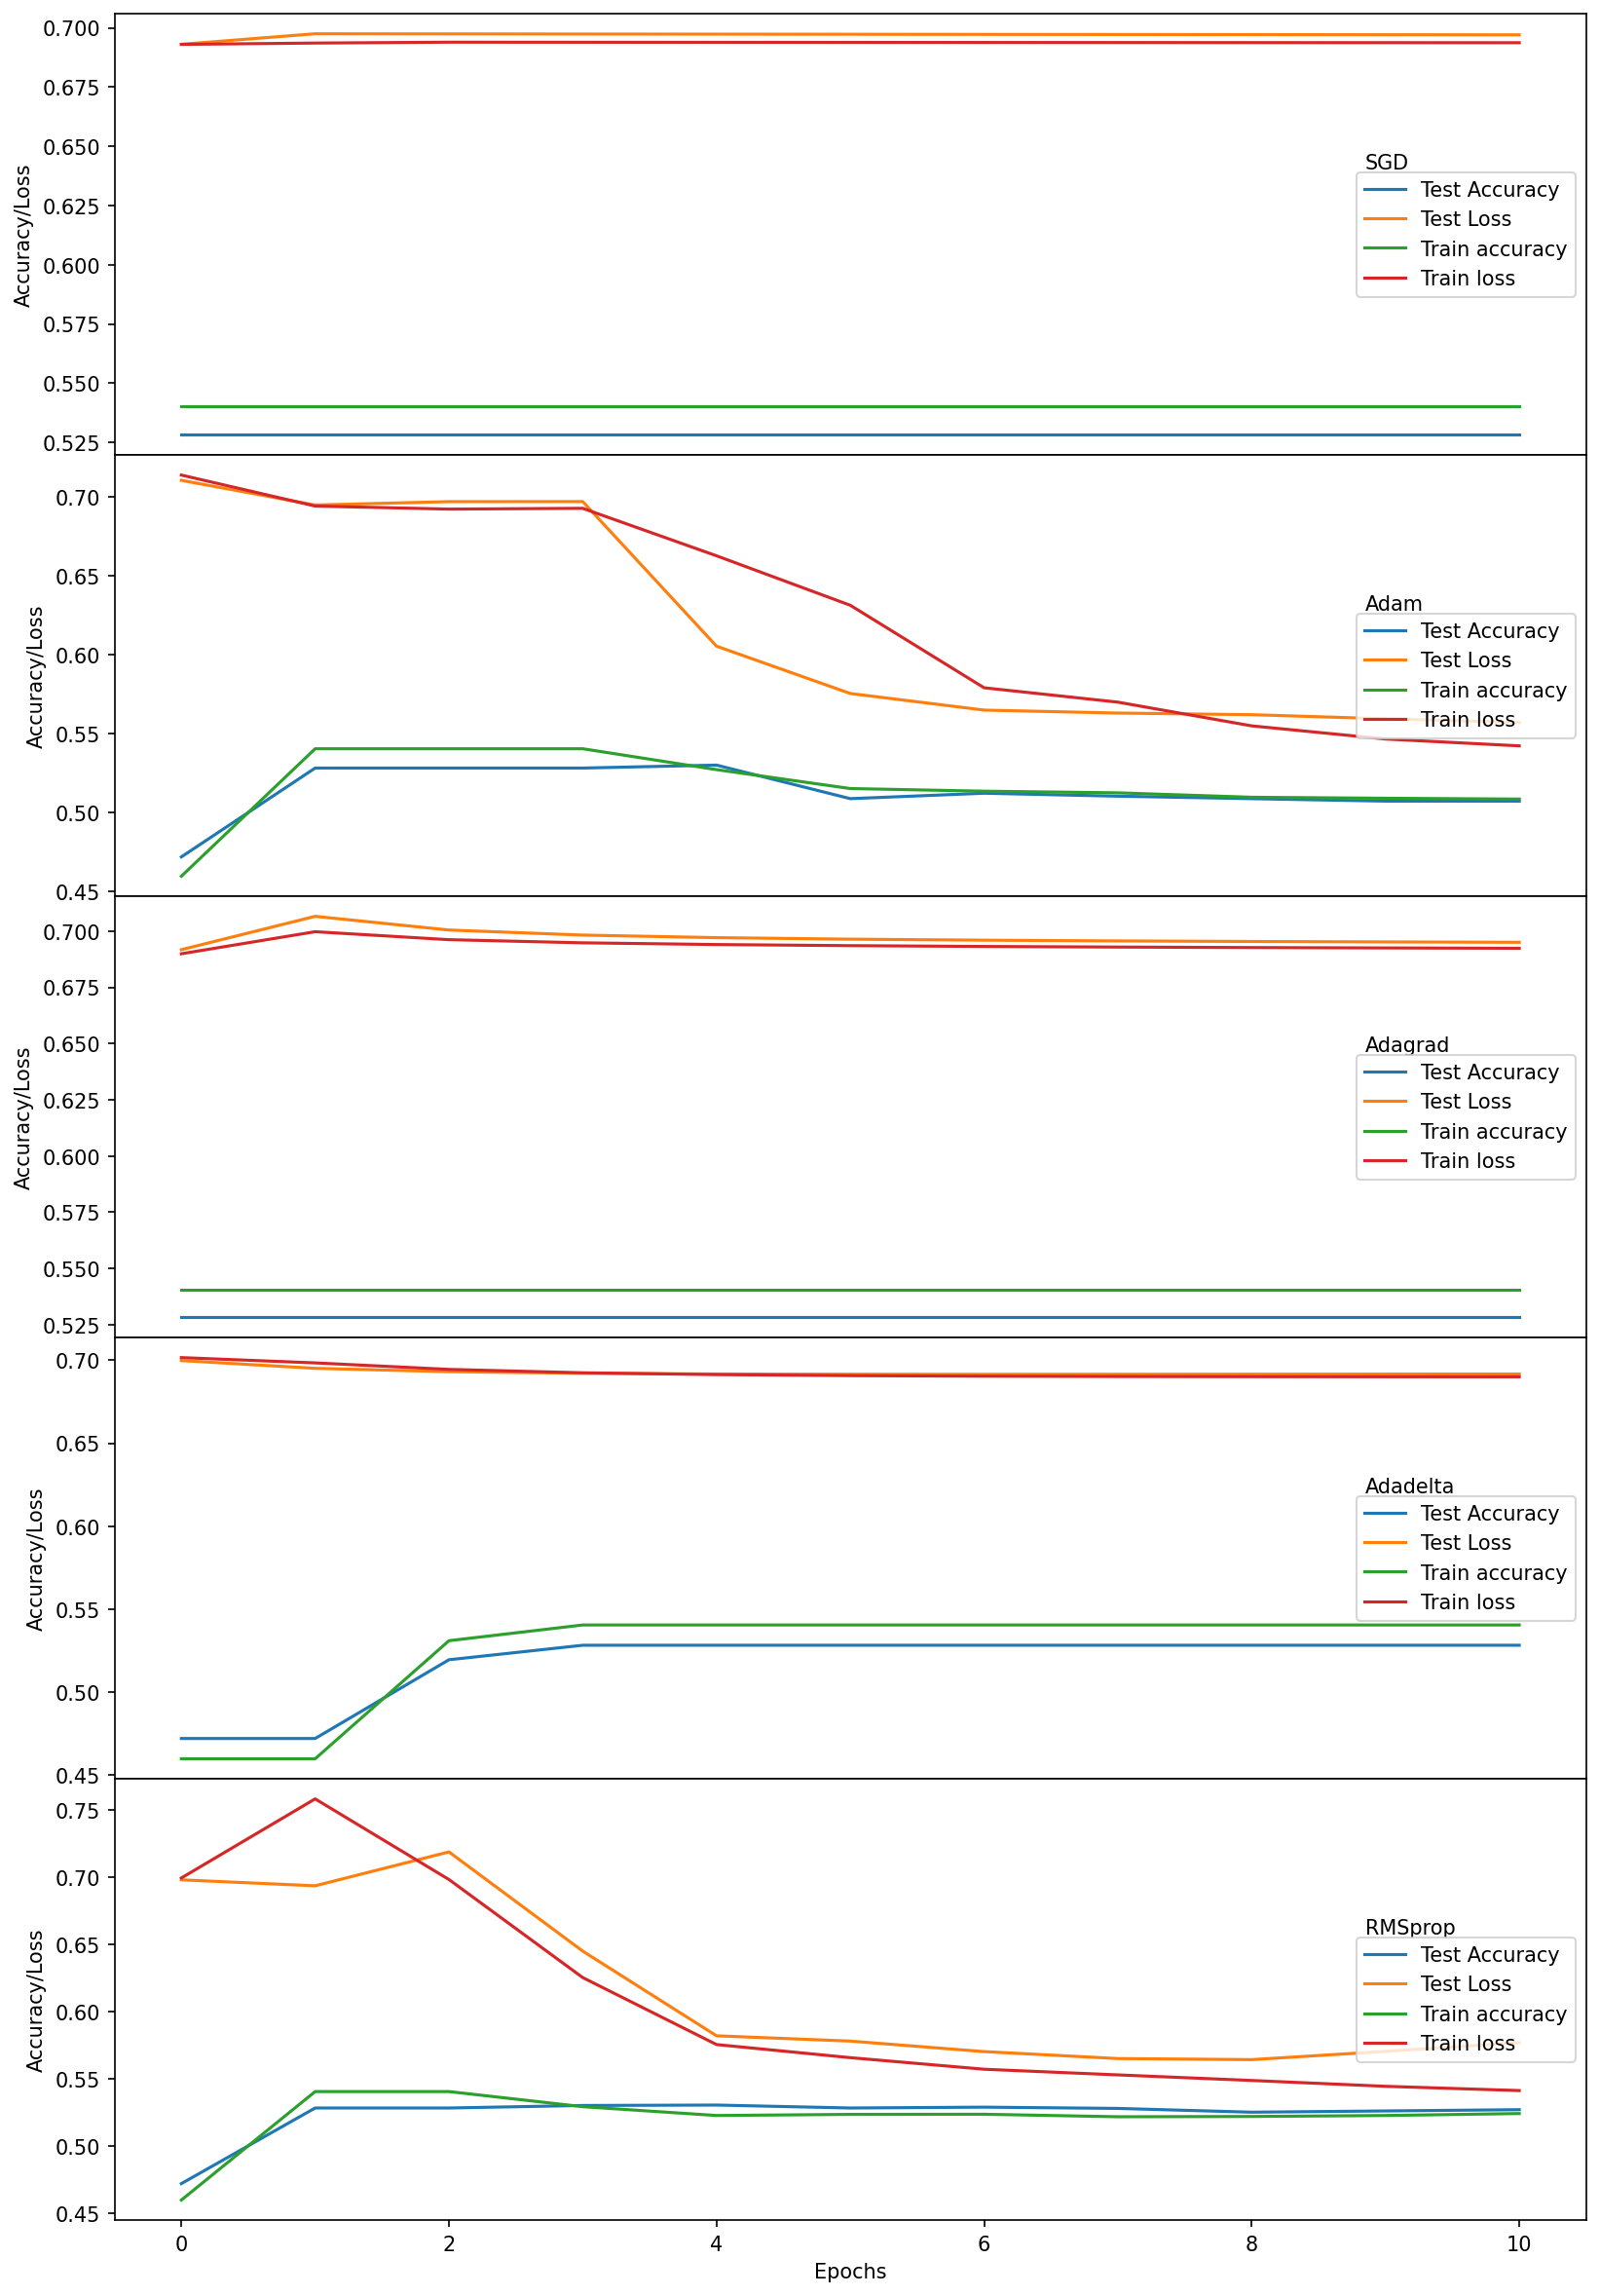

In [856]:
""" Comparing via plot """

fig = plt.figure(figsize=(13,20), dpi=150)
gs = fig.add_gridspec(5,hspace=0)
axs = gs.subplots(sharex=True)

cursor = MultiCursor(fig.canvas,(axs[0],axs[1], axs[2], axs[3], axs[4]),horizOn=False,vertOn=True,color="black",linewidth=1.0)

axs[0].plot(np.arange(0,len(sgd[0])),sgd[0],label='Test Accuracy')
axs[0].plot(np.arange(0,len(sgd[1])),sgd[1],label='Test Loss')
axs[0].plot(np.arange(0,len(sgd[2])),sgd[2],label='Train accuracy')
axs[0].plot(np.arange(0,len(sgd[3])),sgd[3],label='Train loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy/Loss')
axs[0].legend(loc='center right')
axs[0].annotate('SGD',xy=(0.8,0.5),xytext=(0.85,0.65),xycoords='axes fraction',fontsize=10)

axs[1].plot(np.arange(0,len(adam[0])),adam[0],label='Test Accuracy')
axs[1].plot(np.arange(0,len(adam[1])),adam[1],label='Test Loss')
axs[1].plot(np.arange(0,len(adam[2])),adam[2],label='Train accuracy')
axs[1].plot(np.arange(0,len(adam[3])),adam[3],label='Train loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy/Loss')
axs[1].legend(loc='center right')
axs[1].annotate('Adam',xy=(0.8,0.5),xytext=(0.85,0.65),xycoords='axes fraction',fontsize=10)

axs[2].plot(np.arange(0,len(adagrad[0])),adagrad[0],label='Test Accuracy')
axs[2].plot(np.arange(0,len(adagrad[1])),adagrad[1],label='Test Loss')
axs[2].plot(np.arange(0,len(adagrad[2])),adagrad[2],label='Train accuracy')
axs[2].plot(np.arange(0,len(adagrad[3])),adagrad[3],label='Train loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy/Loss')
axs[2].legend(loc='center right')
axs[2].annotate('Adagrad',xy=(0.8,0.5),xytext=(0.85,0.65),xycoords='axes fraction',fontsize=10)

axs[3].plot(np.arange(0,len(adadelta[0])),adadelta[0],label='Test Accuracy')
axs[3].plot(np.arange(0,len(adadelta[1])),adadelta[1],label='Test Loss')
axs[3].plot(np.arange(0,len(adadelta[2])),adadelta[2],label='Train accuracy')
axs[3].plot(np.arange(0,len(adadelta[3])),adadelta[3],label='Train loss')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Accuracy/Loss')
axs[3].legend(loc='center right')
axs[3].annotate('Adadelta',xy=(0.8,0.5),xytext=(0.85,0.65),xycoords='axes fraction',fontsize=10)

axs[4].plot(np.arange(0,len(rmsprop[0])),rmsprop[0],label='Test Accuracy')
axs[4].plot(np.arange(0,len(rmsprop[1])),rmsprop[1],label='Test Loss')
axs[4].plot(np.arange(0,len(rmsprop[2])),rmsprop[2],label='Train accuracy')
axs[4].plot(np.arange(0,len(rmsprop[3])),rmsprop[3],label='Train loss')
axs[4].set_xlabel('Epochs')
axs[4].set_ylabel('Accuracy/Loss')
axs[4].legend(loc='center right')
axs[4].annotate('RMSprop',xy=(0.8,0.5),xytext=(0.85,0.65),xycoords='axes fraction',fontsize=10)


plt.show()
